В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2'

In [4]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andrianazadorozhna
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 86.9MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-2/bank-customer-churn-prediction-dlu-course-c-2.zip to ./bank-customer-churn-prediction-dlu-course-c-2


In [5]:
import os

In [6]:
data_dir = './bank-customer-churn-prediction-dlu-course-c-2'

In [7]:
train_csv = data_dir + '/train.csv'

In [8]:
os.listdir(data_dir)

['train.csv', 'test.csv', 'sample_submission.csv']

In [9]:
import pandas as pd

In [10]:
raw_df = pd.read_csv(train_csv)

In [11]:
raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15807989.0,Ch'iu,585.0,France,Male,33.0,3.0,0.00,1.0,1.0,0.0,54191.38,0.0
14996,14996,15731781.0,Ch'ang,678.0,France,Male,34.0,6.0,0.00,2.0,1.0,1.0,53437.10,0.0
14997,14997,15667093.0,Goliwe,678.0,France,Female,54.0,4.0,0.00,1.0,1.0,0.0,147720.29,1.0
14998,14998,15732644.0,Fanucci,705.0,Spain,Female,40.0,7.0,0.00,2.0,1.0,0.0,149550.95,0.0


In [12]:
raw_df = raw_df.drop(columns=['Surname', 'CustomerId'])

# Optional: Display the updated DataFrame
print(raw_df.head())

   id  CreditScore Geography  Gender   Age  Tenure    Balance  NumOfProducts  \
0   0        678.0    France    Male  29.0     4.0       0.00            3.0   
1   1        687.0    France  Female  34.0     1.0       0.00            2.0   
2   2        682.0    France  Female  52.0     6.0       0.00            3.0   
3   3        753.0   Germany    Male  44.0     6.0   83347.25            2.0   
4   4        544.0   Germany  Female  55.0     0.0  107747.57            1.0   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0        1.0             0.0        180626.36     0.0  
1        0.0             1.0         63736.17     0.0  
2        0.0             0.0        179655.87     1.0  
3        1.0             0.0        161407.48     0.0  
4        1.0             0.0        176580.86     1.0  


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [14]:
target_column = 'Exited'
input_columns = [col for col in raw_df.columns if col != target_column]

train_df, val_df = split_train_val(raw_df, target_col=target_column, test_size=0.2, random_state=42)

X_train, y_train = separate_inputs_targets(train_df, input_cols=input_columns, target_col=target_column)
X_val, y_val = separate_inputs_targets(val_df, input_cols=input_columns, target_col=target_column)

print("Форма X_train:", X_train.shape)
print("Форма y_train:", y_train.shape)
print("Форма X_val:", X_val.shape)
print("Форма y_val:", y_val.shape)


Форма X_train: (12000, 11)
Форма y_train: (12000,)
Форма X_val: (3000, 11)
Форма y_val: (3000,)


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [15]:
X_train.dtypes

,0
id,int64
CreditScore,float64
Geography,object
Gender,object
Age,float64
Tenure,float64
Balance,float64
NumOfProducts,float64
HasCrCard,float64
IsActiveMember,float64


In [16]:
categorical_columns = X_train.select_dtypes(include=['object', 'string']).columns.tolist()
print("Категоріальні ознаки:", categorical_columns)


Категоріальні ознаки: ['Geography', 'Gender']


In [17]:
for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')

In [18]:
print(X_train[categorical_columns].dtypes)
print(X_val[categorical_columns].dtypes)

Geography    category
Gender       category
dtype: object
Geography    category
Gender       category
dtype: object


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [19]:
!pip install xgboost --quiet
import xgboost as xgb
from sklearn.metrics import roc_auc_score

In [20]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,           # Частка використаних даних для кожного дерева
    colsample_bytree=0.8,    # Частка використаних ознак для кожного дерева
    missing=np.nan,
    tree_method='gpu_hist',
    use_label_encoder=False,
    eval_metric='auc',
    enable_categorical=True
)

xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [21]:
# Прогноз ймовірностей
y_train_pred = xgb_model.predict_proba(X_train)[:, 1]
y_val_pred = xgb_model.predict_proba(X_val)[:, 1]

# Розрахунок AUROC
train_auc = roc_auc_score(y_train, y_train_pred)
val_auc = roc_auc_score(y_val, y_val_pred)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9520
Validation AUROC: 0.9350


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


xgb_model дає кращі результати ніж decisiom trees в попередньому дз

In [23]:
#model evaluation
if train_auc > 0.9 and val_auc < 0.75:
    print("Модель перенавчена (high variance).")
elif train_auc < 0.7 and val_auc < 0.7:
    print("Модель недонавчена (high bias).")
else:
    print("Модель має хороший баланс між bias і variance.")


Модель має хороший баланс між bias і variance.


3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [24]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [25]:
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'n_estimators': hp.choice('n_estimators', range(50, 200)),
}

In [26]:
def objective(params):
    model = xgb.XGBClassifier(
        **params,
        tree_method='gpu_hist',
        use_label_encoder=False,
        eval_metric='auc',
        enable_categorical=True
    )
    model.fit(X_train, y_train)
    val_preds = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)
    return {'loss': -val_auc, 'status': STATUS_OK}

In [27]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Найкращі гіперпараметри:", best)

  5%|▌         | 1/20 [00:00<00:02,  6.73trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:29] WARNING: /workspace/src/comm

 10%|█         | 2/20 [00:00<00:03,  4.81trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 4/20 [00:00<00:03,  4.17trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:30] WARNING: /workspace/src/comm

 25%|██▌       | 5/20 [00:01<00:03,  4.09trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:01<00:04,  3.20trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:02<00:04,  3.00trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:02<00:04,  2.71trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 45%|████▌     | 9/20 [00:02<00:04,  2.70trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:03<00:04,  2.48trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 55%|█████▌    | 11/20 [00:03<00:03,  2.93trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 12/20 [00:03<00:02,  3.12trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 65%|██████▌   | 13/20 [00:04<00:02,  3.27trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 75%|███████▌  | 15/20 [00:04<00:01,  3.99trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:33] WARNING: /workspace/src/comm

 80%|████████  | 16/20 [00:04<00:01,  3.95trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:05<00:00,  3.77trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:05<00:00,  3.67trial/s, best loss: -0.9366352287536868]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:34] WARNING: /workspace/src/comm

100%|██████████| 20/20 [00:06<00:00,  3.32trial/s, best loss: -0.9366352287536868]
Найкращі гіперпараметри: {'colsample_bytree': 0.7826189889384576, 'learning_rate': 0.10978690599379262, 'max_depth': 0, 'n_estimators': 8, 'subsample': 0.579901713129492}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



In [28]:
final_clf = xgb.XGBClassifier(
    max_depth=best['max_depth'] + 3,
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    n_estimators=best['n_estimators'] + 50,
    tree_method='gpu_hist',
    use_label_encoder=False,
    eval_metric='auc',
    enable_categorical=True
)

In [29]:
final_clf.fit(X_train, y_train)
train_preds = final_clf.predict_proba(X_train)[:, 1]
val_preds = final_clf.predict_proba(X_val)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:46:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [30]:
train_auc = roc_auc_score(y_train, train_preds)
val_auc = roc_auc_score(y_val, val_preds)

print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9403
Validation AUROC: 0.9366


модель показує дуже хороші результати на тренувальній вибірці, результати на валідаційній вибірці покращились теж в порівняні з моделю з 2 завдання

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [31]:
import lightgbm as lgb

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [32]:
categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()
cat_feature_indices = [X_train.columns.get_loc(col) for col in categorical_features]

In [33]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [34]:
from lightgbm import early_stopping, log_evaluation

In [35]:
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    categorical_feature=cat_feature_indices,
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(period=10)  # Показує лог кожні 10 ітерацій
    ]
)

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
Training until validation scores don't improve for 10 rounds
[10]	valid_0's auc: 0.933137	valid_0's binary_logloss: 0.30686
[20]	valid_0's auc: 0.933852	valid_0's binary_logloss: 0.264755
[30]	valid_0's auc: 0.934419	valid_0's binary_logloss: 0.253484
[40]	valid_0's auc: 0.934451	valid_0's binary_logloss: 0.249669
Early stopping, best iteration is:
[37]	valid_0's auc: 0.934639	valid_0's binary_logloss: 0.250036


LGBMClassifier(colsample_bytree=0.8, max_depth=6, random_state=42,
               subsample=0.8)

In [36]:
train_preds = lgb_model.predict_proba(X_train)[:, 1]
val_preds = lgb_model.predict_proba(X_val)[:, 1]

In [37]:
train_auc = roc_auc_score(y_train, train_preds)
val_auc = roc_auc_score(y_val, val_preds)

In [38]:
print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9534
Validation AUROC: 0.9346


5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [39]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [40]:
param_space = {
    'num_leaves': hp.choice('num_leaves', range(20, 150)),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10)
}

In [41]:
def objective(params):
    model = lgb.LGBMClassifier(
        **params,
        n_estimators=100,
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        categorical_feature=cat_feature_indices

    )
    val_preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_preds)
    return {'loss': -auc, 'status': STATUS_OK}

In [42]:
trials = Trials()
rng = np.random.default_rng(42)

best_params = fmin(
    fn=objective,
    space=param_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials,
    rstate=rng
)

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [43]:
print("Найкращі гіперпараметри:", best_params)

Найкращі гіперпараметри: {'colsample_bytree': 0.6690827907476862, 'learning_rate': 0.07576253355055539, 'max_depth': 1, 'min_child_weight': 3.5862068786791044, 'num_leaves': 67, 'subsample': 0.7514518773307409}


In [44]:
final_lgb_clf = lgb.LGBMClassifier(
    num_leaves=best_params['num_leaves'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=100,
    random_state=42
)

In [45]:
final_lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    categorical_feature=cat_feature_indices
)

[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1098
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMClassifier(colsample_bytree=0.6690827907476862,
               learning_rate=0.07576253355055539, max_depth=1,
               min_child_weight=3.5862068786791044, num_leaves=67,
               random_state=42, subsample=0.7514518773307409)

In [46]:
train_preds = final_lgb_clf.predict_proba(X_train)[:, 1]
val_preds = final_lgb_clf.predict_proba(X_val)[:, 1]

In [47]:
train_auc = roc_auc_score(y_train, train_preds)
val_auc = roc_auc_score(y_val, val_preds)

In [48]:
print(f"Train AUROC: {train_auc:.4f}")
print(f"Validation AUROC: {val_auc:.4f}")

Train AUROC: 0.9240
Validation AUROC: 0.9229


модель не стала кращою після пошуку оптимальних значень гіперпараметрів

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [53]:
test_csv = data_dir + '/test.csv'
test_df = pd.read_csv(test_csv)

In [54]:
test_df = test_df.drop(columns=['Surname', 'CustomerId'])

# Optional: Display the updated DataFrame
print(raw_df.head())

   id  CreditScore Geography  Gender   Age  Tenure    Balance  NumOfProducts  \
0   0        678.0    France    Male  29.0     4.0       0.00            3.0   
1   1        687.0    France  Female  34.0     1.0       0.00            2.0   
2   2        682.0    France  Female  52.0     6.0       0.00            3.0   
3   3        753.0   Germany    Male  44.0     6.0   83347.25            2.0   
4   4        544.0   Germany  Female  55.0     0.0  107747.57            1.0   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0        1.0             0.0        180626.36     0.0  
1        0.0             1.0         63736.17     0.0  
2        0.0             0.0        179655.87     1.0  
3        1.0             0.0        161407.48     0.0  
4        1.0             0.0        176580.86     1.0  


In [55]:
object_cols = test_df.select_dtypes(include='object').columns
print("Категоріальні стовпці:", list(object_cols))

Категоріальні стовпці: ['Geography', 'Gender']


In [56]:
for col in object_cols:
    test_df[col] = test_df[col].astype('category')

In [57]:
test_predictions = final_clf.predict_proba(test_df)[:, 1]

In [58]:
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "Exited": test_predictions
})

In [59]:
submission_df.to_csv("submission_final_clf_2.csv", index=False)

print("Файл submission.csv успішно збережено!")

Файл submission.csv успішно збережено!


In [60]:
from google.colab import files
files.download("submission_final_clf_2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
test_predictions_lgb = final_lgb_clf.predict_proba(test_df)[:, 1]

In [63]:
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "Exited": test_predictions_lgb
})

In [64]:
submission_df.to_csv("submission_final_lgb_clf.csv", index=False)

print("Файл submission.csv успішно збережено!")

Файл submission.csv успішно збережено!


In [66]:
from google.colab import files
files.download("submission_final_lgb_clf.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

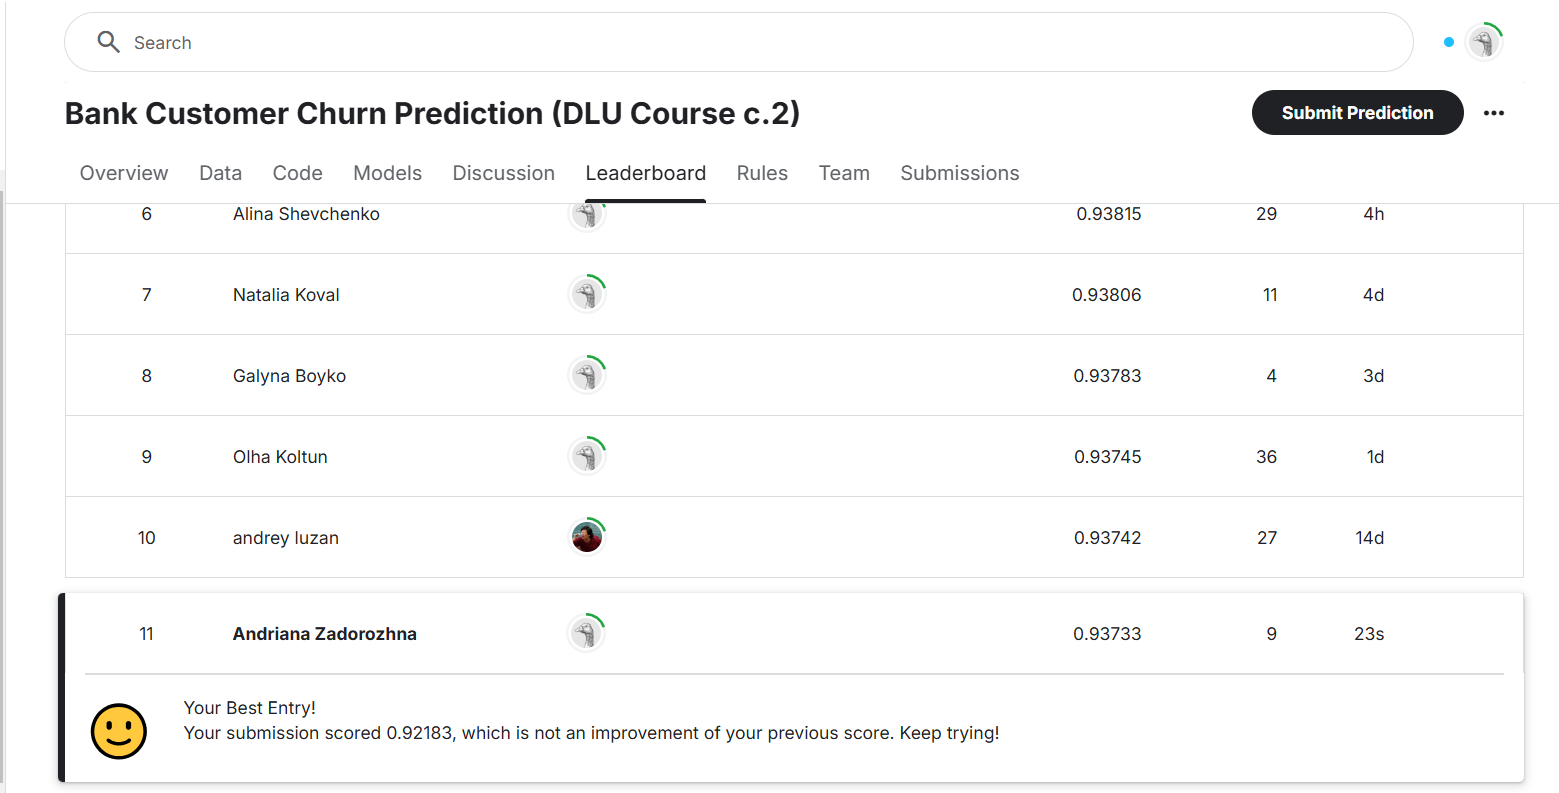

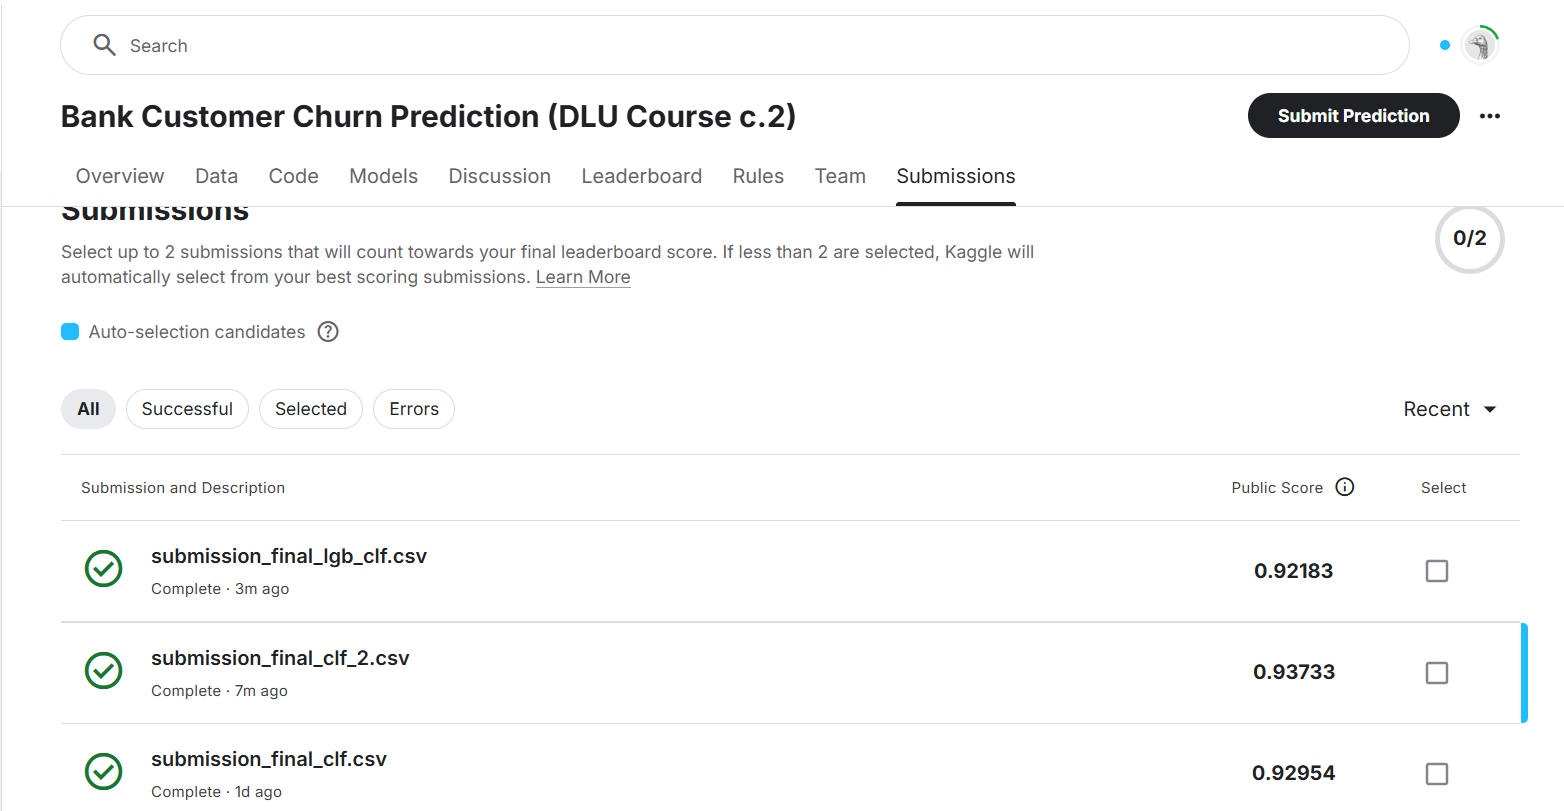